# Udacity Data Scientist Capstone Project: 

# Identify churned users for a music streaming APP

Tianxing Zhai

March 1st, 2020

## 1. Project Definition

### 1.1 Projcet Overview

The problem comes from a fictitious music streaming company called Sparkify. Sparkify has millions of users who use the company's app to stream thier favorite songs everyday. Each user uses either the Free-tier with advertisement between the songs or the premium subscription plan. Users can upgrade, downgrade or cancel thier service at any time. Hence, it is important to predict users who are going to cancel subscriptions (churned users). Knowing who will be churned users, we can take actions to keep paid users before it is too late.


In this project, I will use Spark and Python to analyze the Sparkify user event data. I will also build a machine learning model to predict who are going to cancel. Because the original data is too big (12GB), a tiny subset (128MB) was extracted and will be used in this project. All the analysis and model building will be done on my PC.

### 1.2 Problem Statement

The goal is to identify churned users. The tasks involved are the following:
1. Load and preprocess the user event data.
2. Define and create a label called 'churn'. The label represents whether a user cancels his service.
3. Do feature engineering, make the dataset ready for machine learning.
4. Do the machine learning, including train-test splitting, training, validating and tunning.
5. Write a blog post to communicate the results and findings. 

### 1.3 Metrics

Since the churned users are a fairly small subset, I will use F1 score as the main metric to measure performance of a model and optimize. Recall and precision will also be checked.

## 2. Exploratory Data Analysis and Visualization

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg
from pyspark.sql.functions import count
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import VectorAssembler, StandardScaler

from pyspark.ml.classification import GBTClassifier, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import pandas as pd
import seaborn as sns

%matplotlib inline

Load the data from a local json file:

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("spark project") \
        .getOrCreate()

In [3]:
# read the data in json file
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

The first row of the data:

In [4]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

Check the shape of the data:

In [5]:
print((df.count(), len(df.columns)))

(286500, 18)


The data has 286500 rows and 18 columns.

Current variables of the data:

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Next, check some variables I think are important:

In [7]:
df.createOrReplaceTempView("df")

In [8]:
def count_values(variable):
    # output count table of a variable by using spark SQL
    count_table = spark.sql('''
          SELECT {}, COUNT({}) AS {}_count, COUNT({})/286500*100 AS {}_percent
          FROM df
          GROUP BY {}
          ORDER BY {}_count DESC
          '''.format(variable, variable, variable, variable, variable, variable, variable)
          )
    count_table.show()
    count_table_df = count_table.toPandas()
    sns.barplot(x=variable + '_percent', y=variable, data=count_table_df)
    

+----------+----------+--------------------+
|      auth|auth_count|        auth_percent|
+----------+----------+--------------------+
| Logged In|    278102|   97.06876090750436|
|Logged Out|      8249|  2.8792321116928443|
|     Guest|        97| 0.03385689354275742|
| Cancelled|        52|0.018150087260034906|
+----------+----------+--------------------+



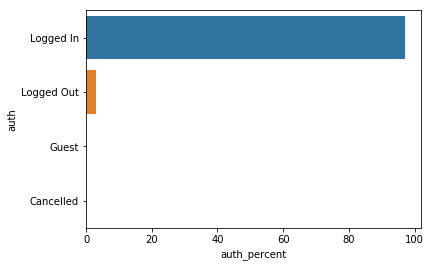

In [9]:
count_table = count_values('auth')

+------+------------+------------------+
|gender|gender_count|    gender_percent|
+------+------------+------------------+
|     F|      154578| 53.95392670157067|
|     M|      123576|43.132984293193715|
|  null|           0|               0.0|
+------+------------+------------------+



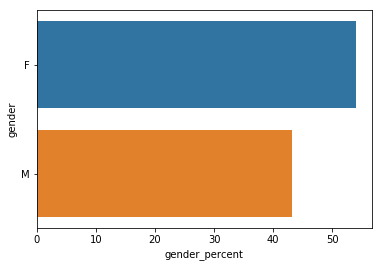

In [10]:
count_values('gender')

+-----+-----------+------------------+
|level|level_count|     level_percent|
+-----+-----------+------------------+
| paid|     228162| 79.63769633507853|
| free|      58338|20.362303664921466|
+-----+-----------+------------------+



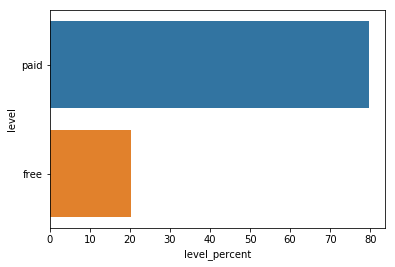

In [11]:
count_values('level')

+--------------------+----------+--------------------+
|                page|page_count|        page_percent|
+--------------------+----------+--------------------+
|            NextSong|    228108|   79.61884816753927|
|                Home|     14457|   5.046073298429319|
|           Thumbs Up|     12551|   4.380802792321116|
|     Add to Playlist|      6526|  2.2778359511343806|
|          Add Friend|      4277|   1.492844677137871|
|         Roll Advert|      3933|  1.3727748691099475|
|               Login|      3241|   1.131239092495637|
|              Logout|      3226|   1.126003490401396|
|         Thumbs Down|      2546|  0.8886561954624781|
|           Downgrade|      2055|  0.7172774869109948|
|                Help|      1726|  0.6024432809773124|
|            Settings|      1514|  0.5284467713787085|
|               About|       924|  0.3225130890052356|
|             Upgrade|       499| 0.17417102966841186|
|       Save Settings|       310|  0.1082024432809773|
|         

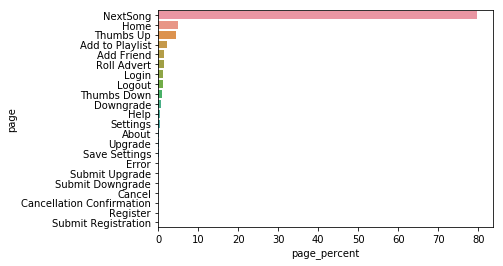

In [12]:
count_values('page')

In [13]:
df.describe("length").show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783722|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



Here is the summary of variables and what I will do on variables:

| Variables | Type | Meaning | Action
| --- | --- | --- | ---|
| artist | string | The artist of the song played| remove|
| auth | string | The register status of users| remove|
| firstname | string | The first names of users| remove|
| gender | string | The gender of users| keep and one-hot encoding|
| itemInSession | int | Unknown| remove|
| lastName | string | The last names of users| remove|
| length | float | The length of the song played | keep and calculate the interaction time |
| level | string | paid or free| use to filter paid users|
| location | string | The location of users| remove|
| method | string | Unknown| remove|
| page | string | The action of users| most important. will be used to create most of features and labels|
| registration | int | Unknown| remove|
| sessionId | int | Unknown| remove|
| song | string | The name of the song played| remove|
| status | int | Unknown| remove|
| ts | int | The timestamp of the action|keep and calculate the record time|
| userAgent | string | The terminal of users used to access the service| remove|
| userId | string | The ID of users| use to identify users|

Deal with missing values in important variables:

In [14]:
# drop missings in the userId and page columns
df_valid = df.dropna(how = "any", subset = ["userId", "page"])

There are blanks in the userId which should be considered as missings as well:

In [15]:
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



Remove blank values:

In [16]:
df_valid = df_valid.filter(df_valid["userId"] != "")

In [17]:
# check after removal 
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [18]:
# before removal
df.count()

286500

In [19]:
# after removal
df_valid.count()

278154

Because we are going to study paid users who will cancel, we don't need to study free users.

In [20]:
# subset paid users
df_valid = df_valid.filter(df_valid["level"] == "paid")

In [21]:
# after subsetting
df_valid.count() 

222433

Collect useful variables for future feature engineering: 

In [22]:
df_valid = df_valid.select(['gender', 'length', 'page', 'ts', 'userId'])

In [23]:
df_valid.show(20)

+------+---------+---------------+-------------+------+
|gender|   length|           page|           ts|userId|
+------+---------+---------------+-------------+------+
|     M|277.89016|       NextSong|1538352117000|    30|
|     M| 282.8273|       NextSong|1538352394000|    30|
|     M|223.60771|       NextSong|1538352676000|    30|
|     M|185.44281|       NextSong|1538352899000|    30|
|     M|     null|Add to Playlist|1538352905000|    30|
|     M|134.47791|       NextSong|1538353084000|    30|
|     M|223.58159|       NextSong|1538353218000|    30|
|     M|246.69995|       NextSong|1538353441000|    30|
|     M|222.22322|       NextSong|1538353687000|    30|
|     M|223.92118|       NextSong|1538353909000|    30|
|     F|250.93179|       NextSong|1538353930000|    54|
|     M|233.32526|       NextSong|1538354132000|    30|
|     F|  216.842|       NextSong|1538354180000|    54|
|     M|219.66322|       NextSong|1538354365000|    30|
|     F|343.32689|       NextSong|1538354396000|

## 3. Methodology

### 3.1 Data Preprocessing

Here is my strategy of data preprocessing and feature engineering:

1. Do some aggregation on users. Make one user per row, rather than one record per row.
2. For gender, transform F and M to 0 and 1.
3. Calculate each user's record hours and interaction hours. The record hours will be calculated as the range of users' timestamp. The interaction hours will be calculated as the sum of length per user.
4. Some user events in the page variable will be counted. They include 4 positive events: NextSong, Thumbs Up, Add to Playlist and Add Friend; 4 negative events: Downgrade, Thumbs Down, Roll Advert and Error.
5. The data is a 'cross section of time', to make aggregations comparable between new and old users, all the counts will be divided by interaction hours and make the **frequency of events per hour of interaction**. The interaction hours will also be divided, by record hours, to make the **proportion of interaction hours among record hours**.
6. The Cancellation Confirmation in the page variable will be used to create the label 'churn'. Anyone who has 'Cancellation Confirmation' will be regarded as churned user and labeled as 1, otherwise 0.

In [24]:
df_valid.createOrReplaceTempView("df_valid")

Calculate interaction hours per user:

In [25]:
spark.sql('''
             SELECT userId, (sum(length))/3600 AS interaction_hours
             FROM df_valid
             GROUP BY userId
             ORDER BY interaction_hours
          '''  
         ).show()

+------+------------------+
|userId| interaction_hours|
+------+------------------+
|    26|              null|
|   122|1.8178796000000002|
|    32| 2.296645277777778|
|   137|2.6664366916666666|
|200007| 4.372185919444445|
|    55|         4.8192491|
|    79| 4.851437647222222|
|200005| 5.533188758333332|
|300024|  6.30517893611111|
|    24| 6.501328494444444|
|300006| 7.777298519444445|
|300007| 7.785752911111117|
|300004| 8.318308313888883|
|200003| 8.550993527777779|
|   151| 9.022538627777777|
|    50| 9.247235361111112|
|    87|  9.49555838611111|
|200014| 11.43981233888889|
|200024|11.665938399999993|
|    11|13.239086922222222|
+------+------------------+
only showing top 20 rows



The user 26 did not have any interactions, remove it from the data and re-calculate interaction hours.

In [26]:
df_valid = df_valid.filter(df_valid["userId"] != 26)

In [27]:
df_valid.createOrReplaceTempView("df_valid")

In [28]:
interaction_hours = spark.sql('''
                                 SELECT userId, (sum(length))/3600 AS interaction_hours
                                 FROM df_valid
                                 GROUP BY userId
                                 ORDER BY userId
                              ''')

In [29]:
interaction_hours.show()

+------+------------------+
|userId| interaction_hours|
+------+------------------+
|    10|46.351770141666655|
|   100|       170.9815182|
|100002|13.766643916666668|
|100004|30.890456986111122|
|100007|29.026479144444455|
|100008| 49.76337765833333|
|100009| 19.56664424166668|
|100012|14.821218402777772|
|100013| 62.17306283611108|
|100014|18.806520022222223|
|100015| 21.79368593055556|
|100016|31.103042672222237|
|100018| 39.89957281944444|
|100023|26.920035438888885|
|100025|22.431072286111124|
|   101|120.34427028055546|
|   103| 60.41290697777779|
|   104|103.91305444722225|
|   105| 52.07377553888891|
|   106| 50.11831493888891|
+------+------------------+
only showing top 20 rows



Calculate record hours per user:

In [30]:
overall_hours = spark.sql('''
                            SELECT userId, (max(ts)-min(ts))*2.7778e-7 AS overall_hours
                            FROM df_valid
                            GROUP BY userId
                            ORDER BY userId
                          ''')

In [31]:
overall_hours.show()

+------+----------------+
|userId|   overall_hours|
+------+----------------+
|    10|1018.49925904000|
|   100|1415.20215486000|
|100002|1322.24141118000|
|100004|1078.28862624000|
|100007|1396.26283668000|
|100008|1013.12949386000|
|100009| 158.31793320000|
|100012| 216.96729128000|
|100013| 692.40165028000|
|100014| 989.87264114000|
|100015|1024.13847082000|
|100016|1272.46740188000|
|100018|1152.03782734000|
|100023| 194.76766924000|
|100025| 436.47876958000|
|   101| 340.63800286000|
|   103| 475.22269064000|
|   104| 864.82302964000|
|   105| 238.10746040000|
|   106| 690.31607804000|
+------+----------------+
only showing top 20 rows



Count those events: NextSong, Thumbs Up, Add to Playlist and Add Friend; Downgrade, Thumbs Down, Roll Advert and Error.

In [32]:
# make a function to count events
def count_events(event):
    
    flag_event = udf(lambda x: 1 if x == event else 0, IntegerType())
    
    event_cat = '_'.join(event.split())
    
    table = df_valid.withColumn(event_cat, flag_event("page")) \
                    .groupby("userId") \
                    .agg(Fsum(event_cat).alias(event_cat + '_n')) \
                    .orderBy('userId') 
    
    return table

In [33]:
# Store count table to 8 tables
table1 = count_events('NextSong')
table2 = count_events('Thumbs Up')
table3 = count_events('Add to Playlist')
table4 = count_events('Add Friend')
table5 = count_events('Submit Downgrade')
table6 = count_events('Thumbs Down')
table7 = count_events('Roll Advert')
table8 = count_events('Error')

Next, recode gender from F and M to 0 and 1:

In [34]:
flag_male = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

male = df_valid.withColumn('M_OR_F', flag_male("gender")) \
                .groupby("userId") \
                .agg(avg('M_OR_F').alias('male')) \
                .orderBy('userId') 

In [35]:
male.show()

+------+----+
|userId|male|
+------+----+
|    10| 1.0|
|   100| 1.0|
|100002| 0.0|
|100004| 0.0|
|100007| 0.0|
|100008| 0.0|
|100009| 1.0|
|100012| 1.0|
|100013| 0.0|
|100014| 1.0|
|100015| 0.0|
|100016| 1.0|
|100018| 1.0|
|100023| 1.0|
|100025| 0.0|
|   101| 1.0|
|   103| 0.0|
|   104| 0.0|
|   105| 1.0|
|   106| 0.0|
+------+----+
only showing top 20 rows



Next, create the label 'churn'

In [36]:
flag_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

label = df_valid.withColumn('Cancellation_Confirmation', flag_event("page")) \
                .groupby("userId") \
                .agg(Fsum('Cancellation_Confirmation').alias('churn')) \
                .orderBy('userId') 

In [37]:
label.show()

+------+-----+
|userId|churn|
+------+-----+
|    10|    0|
|   100|    0|
|100002|    0|
|100004|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100018|    0|
|100023|    1|
|100025|    0|
|   101|    1|
|   103|    1|
|   104|    0|
|   105|    1|
|   106|    1|
+------+-----+
only showing top 20 rows



Join all the tables to make the final dataframe:

In [38]:
df_final = label.join(interaction_hours, "userId") \
                .join(overall_hours, "userId")\
                .join(male, "userId")\
                .join(table1, "userId")\
                .join(table2, "userId")\
                .join(table3, "userId")\
                .join(table4, "userId")\
                .join(table5, "userId")\
                .join(table6, "userId")\
                .join(table7, "userId")\
                .join(table8, "userId")

In [39]:
df_final.show(5)

+------+-----+------------------+----------------+----+----------+-----------+-----------------+------------+------------------+-------------+-------------+-------+
|userId|churn| interaction_hours|   overall_hours|male|NextSong_n|Thumbs_Up_n|Add_to_Playlist_n|Add_Friend_n|Submit_Downgrade_n|Thumbs_Down_n|Roll_Advert_n|Error_n|
+------+-----+------------------+----------------+----+----------+-----------+-----------------+------------+------------------+-------------+-------------+-------+
|200002|    0| 20.25951776666666| 685.89298710000| 1.0|       300|         15|                5|           2|                 0|            5|            0|      0|
|   124|    0|281.19780355277777|1439.93818608000| 0.0|      4079|        171|              118|          74|                 0|           41|            4|      6|
|    51|    1| 145.3544007777778| 378.70858520000| 1.0|      2111|        100|               52|          28|                 0|           21|            0|      1|
|    15|  

Load the Spark dataframe to Pandas dataframe:

In [40]:
df_final_p = df_final.toPandas()

In [41]:
df_final_p.head()

,userId,churn,interaction_hours,overall_hours,male,NextSong_n,Thumbs_Up_n,Add_to_Playlist_n,Add_Friend_n,Submit_Downgrade_n,Thumbs_Down_n,Roll_Advert_n,Error_n
0,200002,0,20.259518,685.89298710000,1.0,300,15,5,2,0,5,0,0
1,124,0,281.197804,1439.93818608000,0.0,4079,171,118,74,0,41,4,6
2,51,1,145.354401,378.70858520000,1.0,2111,100,52,28,0,21,0,1
3,15,0,132.585446,1314.56690534000,1.0,1914,81,59,31,0,14,1,2
4,54,1,166.786789,1027.14099484000,0.0,2402,136,65,28,1,21,3,1


In [42]:
df_final_p.shape

(164, 13)

There are only 164 users in the dataset. The APP had a pretty small user pool...

As described before, calculate the frequency of events per interaction hour and the proportion of interaction hour:

In [43]:
df_final_p_freq = pd.DataFrame()

In [44]:
df_final_p_freq['churn'] = df_final_p['churn']
df_final_p_freq['male'] = df_final_p['male']
df_final_p_freq['interaction_hours_prop'] = df_final_p['interaction_hours']/df_final_p['overall_hours'].astype('float')
df_final_p_freq['NextSong_freq'] = df_final_p['NextSong_n']/df_final_p['interaction_hours']
df_final_p_freq['Thumbs_Up_freq'] = df_final_p['Thumbs_Up_n']/df_final_p['interaction_hours']
df_final_p_freq['Add_to_Playlist_freq'] = df_final_p['Add_to_Playlist_n']/df_final_p['interaction_hours']
df_final_p_freq['Add_Friend_freq'] = df_final_p['Add_Friend_n']/df_final_p['interaction_hours']
df_final_p_freq['Submit_Downgrade_freq'] = df_final_p['Submit_Downgrade_n']/df_final_p['interaction_hours']
df_final_p_freq['Thumbs_Down_freq'] = df_final_p['Thumbs_Down_n']/df_final_p['interaction_hours']
df_final_p_freq['Roll_Advert_freq'] = df_final_p['Roll_Advert_n']/df_final_p['interaction_hours']
df_final_p_freq['Error_freq'] = df_final_p['Error_n']/df_final_p['interaction_hours']

In [45]:
df_final_p_freq.head(10)

,churn,male,interaction_hours_prop,NextSong_freq,Thumbs_Up_freq,Add_to_Playlist_freq,Add_Friend_freq,Submit_Downgrade_freq,Thumbs_Down_freq,Roll_Advert_freq,Error_freq
0,0,1.0,0.029537,14.807855,0.740393,0.246798,0.098719,0.000000,0.246798,0.000000,0.000000
1,0,0.0,0.195285,14.505803,0.608113,0.419633,0.263160,0.000000,0.145805,0.014225,0.021337
2,1,1.0,0.383816,14.523124,0.687974,0.357746,0.192633,0.000000,0.144474,0.000000,0.006880
3,0,1.0,0.100859,14.435974,0.610927,0.444996,0.233811,0.000000,0.105592,0.007542,0.015085
4,1,0.0,0.162380,14.401620,0.815412,0.389719,0.167879,0.005996,0.125909,0.017987,0.005996
5,0,0.0,0.103964,14.846597,1.011799,0.474926,0.185841,0.000000,0.041298,0.000000,0.061947
6,1,1.0,0.018999,13.665473,0.903942,0.372211,0.319038,0.000000,0.159519,0.106346,0.000000
7,0,0.0,0.109200,14.379599,0.726548,0.287592,0.302728,0.000000,0.128660,0.015136,0.022705
8,1,1.0,0.353291,14.483448,0.697998,0.498570,0.232666,0.000000,0.124642,0.008309,0.024928
9,0,0.0,0.011703,14.502511,0.604271,0.604271,0.075534,0.075534,0.151068,0.075534,0.075534


Save the final dataset to a csv file on my local computer. Because Spark does not support exporting data to non-Hadoop-support file system (the local computer), I use this way to do data exportation.

In [46]:
df_final_p_freq.to_csv('df_final.csv', index = False)

As the final data is pretty small (only 164 rows), I don't need to use Spark to do machine learning. But to practice, I will use Spark this time.

In [47]:
# read the csv to Spark dataframe
df_final = spark.read.csv('df_final.csv', header = True, inferSchema = True)

In [48]:
df_final.show(10)

+-----+----+----------------------+------------------+------------------+--------------------+-------------------+---------------------+--------------------+--------------------+--------------------+
|churn|male|interaction_hours_prop|     NextSong_freq|    Thumbs_Up_freq|Add_to_Playlist_freq|    Add_Friend_freq|Submit_Downgrade_freq|    Thumbs_Down_freq|    Roll_Advert_freq|          Error_freq|
+-----+----+----------------------+------------------+------------------+--------------------+-------------------+---------------------+--------------------+--------------------+--------------------+
|    0| 1.0|  0.029537432438732483|  14.8078549279981| 0.740392746399905|  0.2467975821333017|0.09871903285332068|                  0.0|  0.2467975821333017|                 0.0|                 0.0|
|    0| 0.0|   0.19528463532055745|14.505803204947211|0.6081128580647152|  0.4196334342200958|0.26315995027361944|                  0.0| 0.14580483731376212|  0.0142248621769524|0.021337293265428603|


Split the dataset into training (80%) and testing (20%):

In [49]:
training, testing = df_final.randomSplit([0.8, 0.2],seed = 5)

Exam the balance in training and testing data:

In [50]:
df_final.filter(df_final['churn'] == 1).count()/df_final.count()

0.18902439024390244

In [51]:
training.filter(training['churn'] == 1).count()/training.count()

0.1875

In [52]:
testing.filter(training['churn'] == 1).count()/testing.count()

0.19444444444444445

The proportion of the positive labels in the training and testing is close to the proportion in original data (~19%).

Assemble all features together into one column:

In [53]:
assembler = VectorAssembler(inputCols=['male', 'interaction_hours_prop', 'NextSong_freq',
       'Thumbs_Up_freq', 'Add_to_Playlist_freq', 'Add_Friend_freq',
       'Submit_Downgrade_freq', 'Thumbs_Down_freq', 'Roll_Advert_freq',
       'Error_freq'], outputCol="features")

In [54]:
training_as = assembler.transform(training).select(['churn', 'features'])
testing_as = assembler.transform(testing).select(['churn', 'features'])

Standardize training and testing dataset:

In [55]:
scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="features_std", withStd=True)

In [56]:
training_as_std = scaler.fit(training_as).transform(training_as).select(['churn', 'features_std'])
testing_as_std = scaler.fit(training_as).transform(testing_as).select(['churn', 'features_std'])

### 3.2 Implementation

I will use three classification algorithms: Logistic Regression (LogisticRegression), Linear Support Vector Machines (LinearSVC) and Gradient-Boosted Trees (GBTClassifier). I will train them on the training data and test the performace on the testing data. F1, recall and precision on the testing data will be reported.

In [57]:
def train_evaluate(model, training, testing):
    # the function is to train the model and evaluate its performance on testing dataset
    
    f1 = MulticlassClassificationEvaluator(labelCol='churn',  metricName='f1')
    recall = MulticlassClassificationEvaluator(labelCol='churn',  metricName='weightedRecall')
    precision = MulticlassClassificationEvaluator(labelCol='churn',  metricName='weightedPrecision')
    
    model_trained = model.fit(training)
    model_pred = model_trained.transform(testing)
    
    print('On testing data, the F1 is: {}, recall is: {}, precision is: {}'.format(f1.evaluate(model_pred), recall.evaluate(model_pred), precision.evaluate(model_pred)))

In [58]:
# define classifiers
lr = LogisticRegression(featuresCol = 'features_std', labelCol = 'churn')
svc = LinearSVC(featuresCol = 'features_std', labelCol = 'churn')
gbt = GBTClassifier(featuresCol = 'features_std', labelCol = 'churn')

The results of Logistic Regression (LogisticRegression) model:

In [59]:
train_evaluate(lr, training_as_std, testing_as_std)

On testing data, the F1 is: 0.7037037037037037, recall is: 0.7222222222222222, precision is: 0.6885304659498207


The results of Linear Support Vector Machines (LinearSVC) model:

In [60]:
train_evaluate(svc, training_as_std, testing_as_std)

On testing data, the F1 is: 0.7188034188034188, recall is: 0.8055555555555556, precision is: 0.6489197530864197


The results of Gradient-Boosted Trees (GBTClassifier) model:

In [61]:
train_evaluate(gbt, training_as_std, testing_as_std)

On testing data, the F1 is: 0.7629629629629628, recall is: 0.7777777777777778, precision is: 0.7534050179211469


The GBTClassifier model has the best performace so far, in terms of F1. In next part, I will tune the model and try to get better results. 

### 3.3 Refinement

I will tune three hyperparameters of the GBTClassifier:
1. maxDepth. Option are 3, 5, 7.
2. stepSize. Option are 0.05, 0.1, 0.5.
3. featureSubsetStrategy. Option are 'all' and 'auto'.

I will use CrossValidator in Spark (similar as GridSearchCV in scikit-learn) to do the tuning.

In [62]:
# define hyperparameters for choice
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.5]) \
    .addGrid(gbt.featureSubsetStrategy, ['all', 'auto']) \
    .build()

In [63]:
# define the CrossValidator
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn',  metricName='f1'),
                          numFolds=3)

In [64]:
# train the CrossValidator
gbt_tunned = crossval.fit(training_as_std)

The bset maxDepth is 7.

In [65]:
gbt_tunned.bestModel.getOrDefault('maxDepth')

3

The bset stepSize is 0.05.

In [66]:
gbt_tunned.bestModel.getOrDefault('stepSize')

0.5

The best featureSubsetStrategy is 'all'.

In [67]:
gbt_tunned.bestModel.getOrDefault('featureSubsetStrategy')

'all'

Test the performace of the best model on testing data:

In [68]:
gbt_pred = gbt_tunned.transform(testing_as_std)

In [69]:
f1 = MulticlassClassificationEvaluator(labelCol='churn',  metricName='f1')
recall = MulticlassClassificationEvaluator(labelCol='churn',  metricName='weightedRecall')
precision = MulticlassClassificationEvaluator(labelCol='churn',  metricName='weightedPrecision')

print('On testing data, the F1 is: {}, recall is: {}, precision is: {}'.format(f1.evaluate(gbt_pred), recall.evaluate(gbt_pred), precision.evaluate(gbt_pred)))

On testing data, the F1 is: 0.742503259452412, recall is: 0.75, precision is: 0.736111111111111


We can see that after tuning, on the testing data, the F1 is: 0.7220566318926974, recall is: 0.75, precision is: 0.703125.

## 4. Results

### 4.1 Model Evaluation and Validation

I tried three different algorithms: Logistic Regression (LogisticRegression), Linear Support Vector Machines (LinearSVC) and Gradient-Boosted Trees (GBTClassifier). The performance of models on testing data with default hyperparameters is listed below. The GBTClassifier has the best performance (F1: 0.763, Recall: 0.778, Precision: 0.753).

Then I tunned three hyperparameters of the GBTClassifier using the Spark CrossValidator. The bset maxDepth is 7,  stepSize is 0.05 and featureSubsetStrategy is 'all'. On testing data, the performance of best model is: F1: 0.722, Recall: 0.750, Precision: 0.703. After tuning, the performance gets worse.

| Models | F1 | Recall | Precision|
| --- | --- | --- | ---|
| Logistic Regression | 0.704 | 0.722 | 0.689|
| Linear SVC | 0.719| 0.806 | 0.649|
| GBT Classifier | 0.763 | 0.778 | 0.753|
| GBT Classifier (tuned) | 0.722 | 0.750 | 0.703|

### 4.2 Discussion

Why the GBTClassifier performs worse after tuning? In my opinion, there are three possible reasons:

1. **Small training (128) and testing (36) data.** The dataset is pretty small, there are not enough training data to make model robust. And there are not nough testing data to make evaluation so credible. So we can't conclude firmly the results are 'worse'.
2. **Unbalanced labels.** There are much fewer positive cases in the label (~19%). The train-validation splitter in the CrossValidator is a random splitter rather than a stratified splitter. Some extreme cases may occur: For example, there are no positive cases in validation data. In this time of cross validation, the metrics on the validation data is not reliable. And the best model selected based on metrics is not a real best model. 
3. **Overfitting.** Compared with the default hyperparameters, the maxDepth increases from 5 to 7 and the stepSize decreases from 0.1 to 0.05. Both of the changes will make the GBTClassifier more conservative and more likely to be overfitting. Overfitting can cause bad performance on testing data.

## 5. Conclusion

### 5.1 Reflection

In this project, I used Spark and Python to build a model to identify churned users. Here are my process and findings:

1. I loaded the data (128MB subset of the 12GB data) and did the exploratory data analysis. The data had 286500 rows and 18 variables. I analyzed some important variables and decided to keep 6 variables. Among 6 variables, 'page' was the most important one. It recorded what a user did specifically using the APP.


2. I removed rows with missings in 'userId' and 'page'. I also found there were blanks in the 'userId'. Blanks should be considered as missing and removed. I also removed free users, because we only interested in paid users who will cancel. After removal, the data had 222433 rows and 6 variables.


3. To create features, I did some aggregation on users to make one user per row. I created 10 features, 8 of them were counts of events per interaction hour, 1 is number of interaction hours per record hour, 1 is the gender. I also created the label. It represented whether a user confirmed the cancellation (1 is yes, 0 is no). The final dataset had 164 rows (164 unique users), 10 features and 1 label. Among 164 unique users, 31 of them (~19%) confirmed the cancellation and be labeled as 1.


4. I splited the dataset into training (80%) and testing (20%). The distribution of positive cases in both datasets was checked. Both datasets had about 19% positive cases. Then a StandardScaler was fitted using the training dataset and used to transform both the training and testing data.


5. I tried three different algorithms to bulid the classifier: Logistic Regression (LogisticRegression), Linear Support Vector Machines (LinearSVC) and Gradient-Boosted Trees (GBTClassifier). The GBTClassifier had the best performance on testing data (F1: 0.763, Recall: 0.778, Precision: 0.753).


6. I tunned three hyperparameters of the GBTClassifier using the Spark CrossValidator. The bset maxDepth is 7, stepSize is 0.05 and featureSubsetStrategy is 'all'. On testing data, the performance of best model is: F1: 0.722, Recall: 0.750, Precision: 0.703. After tuning, the performance gets worse. I provided three possible reasons: (1) Small training and testing data. (2) Unbalance labels and (3) Overfitting.


In a word, I developed a classifer to predict users who are going to unsubscribe. The best model had F1 of 0.763 on the testing data.

### 5.2 Improvement

The project was not perfectly done. There are still some spaces to improve:

1. Because of aggregation, the final dataset only have 164 rows (164 unique users). This is a pretty small dataset. The small size makes training and testing unreliable. In the future, I need to train and test models on the 12GB dataset again, rather than directly apply the model here to the larger dataset.


2. The data is unbalanced. We need some methods to deal with the problem. For example, when splitting the data into traning, validating and testing, we need a stratified spliter rather than random spliter. When training models, we can use upsampling (like SMOTE) or downsampling tricks to balance the impact of positive and negative cases. Unfortunately, these functions are not bulit in current Spark library. So I did not deal with the unbalance problem.


3. I counted some events of users of the whole dataset, and used these counts to build most of features. This is a easy and lazy way to do feature engineering. Although the results looked good (F1: 0.763, Recall: 0.778, Precision: 0.753), the applcation of the model is still limited: It can only predict who are going to cancel **in the end**, but cannot make **real-time** prediction, which is exactly what the company want. The company wants to predict future cancellation based on a few 'abnormal' events of users happen in a very short time period before it really happens. So the company can make some timely interventions to prevent possible cancellation. Make prediction timely is another tough problem, which I cannot solve this time. Maybe using Saprk streaming can help.